# chess.com

In [68]:
import concurrent.futures
import matplotlib.pyplot as plt
import pandas
import requests
from requests.adapters import HTTPAdapter, Retry
from tqdm.notebook import tqdm

## Utils

In [69]:
def chunks(list, n):
    # looping till length l
    for i in range(0, len(list), n):
        yield list[i:i + n]

session = requests.Session()
retries = Retry(total=5)
session.mount('https://', HTTPAdapter(max_retries=retries))

## Declare API

In [70]:
CHUNK_SIZE = 1000

MAIN_API = "https://api.chess.com/pub"
PROXY_API = "https://homapis.vercel.app/api/chess.com"

## Get Titled Players

In [71]:
title_abbreviations = ["GM", "WGM", "IM", "WIM", "FM", "WFM", "NM", "WNM", "CM", "WCM"]

title_players = []

for title_abbreviation in tqdm(title_abbreviations):
    url = f"{MAIN_API}/titled/{title_abbreviation}"
    response = session.get(url, timeout=10)
    data = response.json()
    players = data["players"]
    for player in players:
        title_players.append({
            "username": player,
            "title_abbreviation": title_abbreviation
        })

title_players_data_frame = pandas.DataFrame.from_dict(title_players)
sorted_title_players_data_frame = title_players_data_frame.sort_values(by = ["username"], ascending = True)
sorted_title_players_data_frame.to_csv(r'data/csv/title_players.csv', index = False, header = True)

  0%|          | 0/10 [00:00<?, ?it/s]

### Chunk Title Players

In [72]:
chunks_title_players = list(chunks(title_players, CHUNK_SIZE))

# Get Titled Profiles

### Get Profile

In [73]:
def get_profile(username):
    profile_url = f"{PROXY_API}/player/{username}"
    try:
        response = session.get(profile_url, timeout=10)
        if response.status_code == 200:
            profile = response.json()
            return profile
        else:
            print(username, response.status_code)
            return {
                "username": username
            }
    except Exception as error:
        print(username, error)
        return {
            "username": username
        }

### Get Profiles

In [74]:
title_profiles = []

for chunk_title_players in tqdm(chunks_title_players):
    usernames = list(map(lambda title_player: title_player["username"], chunk_title_players))
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for username in usernames:
            futures.append(executor.submit(get_profile, username=username))
        for future in concurrent.futures.as_completed(futures):
            profile = future.result()
            title_profiles.append(profile)
    title_profiles_data_frame = pandas.DataFrame.from_dict(title_profiles)
    sorted_title_profiles_data_frame = title_profiles_data_frame.sort_values(by = ["username"], ascending = True)
    sorted_title_profiles_data_frame.to_csv(r'data/csv/title_profiles.csv', index = False, header = True)

  0%|          | 0/12 [00:00<?, ?it/s]

### Get Verified Profiles

In [75]:
verified_title_profiles = list(filter(lambda title_profile: title_profile["verified"], title_profiles))

verified_title_profiles_data_frame = pandas.DataFrame.from_dict(verified_title_profiles)
sorted_verified_title_profiles_data_frame = verified_title_profiles_data_frame.sort_values(by = ["username"], ascending = True)
sorted_verified_title_profiles_data_frame.to_csv(r'data/csv/verified_title_profiles.csv', index = False, header = True)

### Chunk Verified Profiles

In [77]:
chunks_verified_title_profiles = list(chunks(verified_title_profiles, CHUNK_SIZE))

## Get Title Stats

### Get Player's Stats

In [78]:
def get_stats(username):
    stats_url = f"{PROXY_API}/player/{username}/stats"
    try:
        response = session.get(stats_url, timeout=10)
        if response.status_code == 200:
            stats = response.json()
            fide = stats.get("fide", 0)
            # Rapid
            rapid_rating_best = stats.get("chess_rapid", {}).get("best", {}).get("rating", 0)
            rapid_rating_last = stats.get("chess_rapid", {}).get("last", {}).get("rating", 0)
            rapid_rating_rd = stats.get("chess_rapid", {}).get("last", {}).get("rd", 0)
            rapid_record_win = stats.get("chess_rapid", {}).get("record", {}).get("win", 0)
            rapid_record_draw = stats.get("chess_rapid", {}).get("record", {}).get("draw", 0)
            rapid_record_loss = stats.get("chess_rapid", {}).get("record", {}).get("loss", 0)
            # Blitz
            blitz_rating_best = stats.get("chess_blitz", {}).get("best", {}).get("rating", 0)
            blitz_rating_last = stats.get("chess_blitz", {}).get("last", {}).get("rating", 0)
            blitz_rating_rd = stats.get("chess_blitz", {}).get("last", {}).get("rd", 0)
            blitz_record_win = stats.get("chess_blitz", {}).get("record", {}).get("win", 0)
            blitz_record_draw = stats.get("chess_blitz", {}).get("record", {}).get("draw", 0)
            blitz_record_loss = stats.get("chess_blitz", {}).get("record", {}).get("loss", 0)
            # Bullet
            bullet_rating_best = stats.get("chess_bullet", {}).get("best", {}).get("rating", 0)
            bullet_rating_last = stats.get("chess_bullet", {}).get("last", {}).get("rating", 0)
            bullet_rating_rd = stats.get("chess_bullet", {}).get("last", {}).get("rd", 0)
            bullet_record_win = stats.get("chess_bullet", {}).get("record", {}).get("win", 0)
            bullet_record_draw = stats.get("chess_bullet", {}).get("record", {}).get("draw", 0)
            bullet_record_loss = stats.get("chess_bullet", {}).get("record", {}).get("loss", 0)
            return {
                "username": username,
                "fide": fide,
                "rapid_rating_best": rapid_rating_best,
                "rapid_rating_last": rapid_rating_last,
                "rapid_rating_rd": rapid_rating_rd,
                "rapid_record_win": rapid_record_win,
                "rapid_record_draw": rapid_record_draw,
                "rapid_record_loss": rapid_record_loss,
                "blitz_rating_best": blitz_rating_best,
                "blitz_rating_last": blitz_rating_last,
                "blitz_rating_rd": blitz_rating_rd,
                "blitz_record_win": blitz_record_win,
                "blitz_record_draw": blitz_record_draw,
                "blitz_record_loss": blitz_record_loss,
                "bullet_rating_best": bullet_rating_best,
                "bullet_rating_last": bullet_rating_last,
                "bullet_rating_rd": bullet_rating_rd,
                "bullet_record_win": bullet_record_win,
                "bullet_record_draw": bullet_record_draw,
                "bullet_record_loss": bullet_record_loss
            }
        else:
            print(username, response.status_code)
            return {
                "username": username
            }
    except Exception as error:
        print(username, error)
        return {
            "username": username
        }

### Get All Stats

In [79]:
title_stats = []

for chunk_title_players in tqdm(chunks_title_players):
    usernames = list(map(lambda title_player: title_player["username"], chunk_title_players))
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for username in usernames:
            futures.append(executor.submit(get_stats, username=username))
        for future in concurrent.futures.as_completed(futures):
            stats = future.result()
            title_stats.append(stats)
    title_stats_data_frame = pandas.DataFrame.from_dict(title_stats)
    sorted_title_stats_data_frame = title_stats_data_frame.sort_values(by = ["username"], ascending = True)
    sorted_title_stats_data_frame.to_csv(r'data/csv/title_stats.csv', index = False, header = True)

  0%|          | 0/12 [00:00<?, ?it/s]

### Get Verified Stats

In [80]:
verified_title_stats = []

for chunk_verified_title_profiles in tqdm(chunks_verified_title_profiles):
    usernames = list(map(lambda title_player: title_player["username"], chunk_verified_title_profiles))
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for username in usernames:
            futures.append(executor.submit(get_stats, username=username))
        for future in concurrent.futures.as_completed(futures):
            stats = future.result()
            verified_title_stats.append(stats)
    verified_title_stats_data_frame = pandas.DataFrame.from_dict(verified_title_stats)
    sorted_verified_title_stats_data_frame = verified_title_stats_data_frame.sort_values(by = ["username"], ascending = True)
    sorted_verified_title_stats_data_frame.to_csv(r'data/csv/verified_title_stats.csv', index = False, header = True)

  0%|          | 0/1 [00:00<?, ?it/s]

## Merge Profiles and Stats

In [81]:
verified_title_players_data_frame = pandas.merge(verified_title_profiles_data_frame, verified_title_stats_data_frame)
sorted_verified_title_players_data_frame = verified_title_players_data_frame.sort_values(by = ["username"], ascending = True)
sorted_verified_title_players_data_frame.to_csv(r'data/csv/verified_title_players.csv', index = False, header = True)

## Analyse Verified Title Players

### Filter Top Title

In [82]:
TOP_TITLE = ["FM", "IM", "GM"]

verified_title_players = verified_title_players_data_frame.to_dict('records')
verified_top_title_players = list(filter(lambda title_player: title_player["title"] in TOP_TITLE, verified_title_players))

verified_top_title_stats_data_frame = pandas.DataFrame.from_dict(verified_top_title_players)
sorted_verified_top_title_stats_data_frame = verified_top_title_stats_data_frame.sort_values(by = ["username"], ascending = True)
sorted_verified_top_title_stats_data_frame.to_csv(r'data/csv/verified_top_title_players.csv', index = False, header = True)

### Check Rapid Best Rating

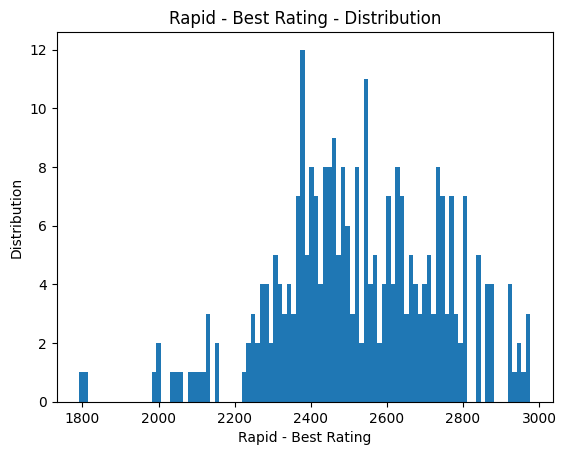

In [83]:
rapid_rating_best_verified_title_players = list(map(lambda title_player: title_player["rapid_rating_best"], verified_top_title_players))
rapid_rating_best_verified_title_players = list(filter(lambda rapid_rating_best: rapid_rating_best > 0, rapid_rating_best_verified_title_players))

plt.hist(rapid_rating_best_verified_title_players, 100)
plt.title("Rapid - Best Rating - Distribution")
plt.xlabel("Rapid - Best Rating")
plt.ylabel("Distribution")
plt.show()

### Check Blitz Best Rating

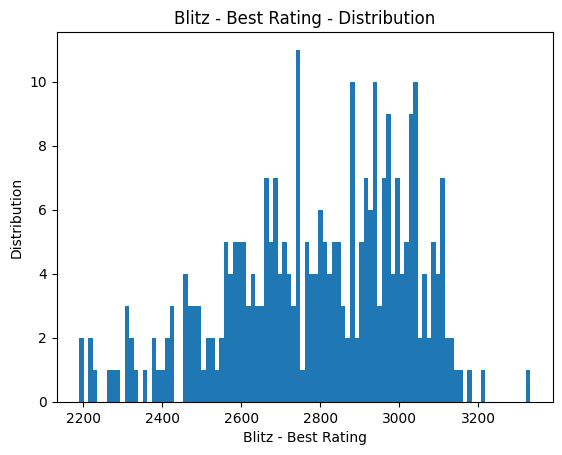

In [84]:
blitz_rating_best_verified_title_players = list(map(lambda title_player: title_player["blitz_rating_best"], verified_top_title_players))
blitz_rating_best_verified_title_players = list(filter(lambda rapid_rating_best: rapid_rating_best > 0, blitz_rating_best_verified_title_players))

plt.hist(blitz_rating_best_verified_title_players, 100)
plt.title("Blitz - Best Rating - Distribution")
plt.xlabel("Blitz - Best Rating")
plt.ylabel("Distribution")
plt.show()

### Check Bullet Best Rating

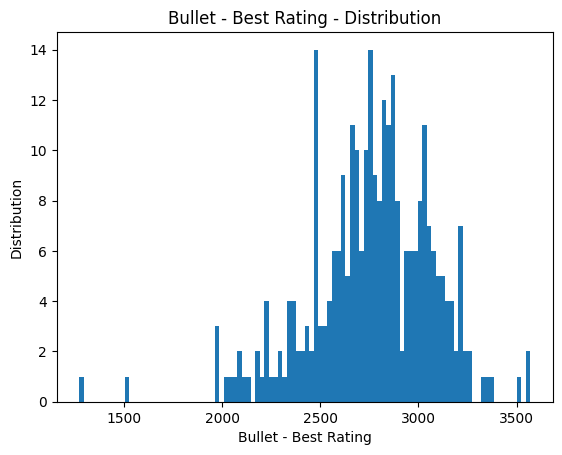

In [85]:
bullet_rating_best_verified_title_players = list(map(lambda title_player: title_player["bullet_rating_best"], verified_top_title_players))
bullet_rating_best_verified_title_players = list(filter(lambda rapid_rating_best: rapid_rating_best > 0, bullet_rating_best_verified_title_players))

plt.hist(bullet_rating_best_verified_title_players, 100)
plt.title("Bullet - Best Rating - Distribution")
plt.xlabel("Bullet - Best Rating")
plt.ylabel("Distribution")
plt.show()